# Emissions Intensity Heatmaps

This notebook is to determine which plants have increased emissions intensity, which have decreased, why the emissions intensity has changed, and by how much. We start by plotting the data, and looking at various aggregations.

In [2]:
import numpy as np
import pandas as pd  # Note: need v 0.24.1
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
sns.set()
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":24,"axes.labelsize":20,"axes.suptitlesize":30})

In [3]:
EI = pd.read_csv('emissionsIntensity.csv')
print(EI.shape[0]/3)
EI.head()

725.0


,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,87,1,Escalante,coal,CO2,1.140423,0.995313,0.917968,0.989163,1.009391,...,1.105578,1.139843,1.177716,1.144533,1.105952,1.050198,0.996492,1.036716,1.056700,1.062672
1,87,1,Escalante,coal,SO2,1.554520,1.348214,1.188432,1.276701,1.268912,...,1.336621,1.356052,1.428336,1.305897,1.169239,0.980457,1.158256,1.281471,1.274391,1.195515
2,87,1,Escalante,coal,NOX,4.300777,3.925008,3.559608,3.884382,3.725776,...,3.685115,3.481987,3.846905,3.747445,3.733149,3.455141,3.351200,3.475148,3.608294,3.741219
3,113,1,Cholla,coal,CO2,1.167588,1.170753,1.106735,1.060301,1.047829,...,1.178634,1.154394,1.134915,1.127551,1.147178,1.152896,1.170352,1.313986,1.287809,1.302087
4,113,1,Cholla,coal,SO2,2.047569,2.166203,1.706805,1.632499,1.614211,...,1.216816,1.658520,2.233263,1.521215,1.485904,1.407100,1.333497,1.256306,1.141691,1.026894


#### Filter to manage missing data

Investigate how much of the plant data is missing.

In [4]:
print('Units included: ', EI.shape[0]/3)  # 3 rows for each, because we have CO2, SO2, and NOx
EI_01_18 = EI.dropna()
print('Units with data for 2001 - 2018: ', EI_01_18.shape[0]/3)
EI_01_18.head()
print('Units missing metadata: ', EI.shape[0]/3 - EI.dropna(subset=['ORISPL_CODE', 'UNITID', 'NAME', 'GAS']).shape[0]/3)

Units included:  725.0
Units with data for 2001 - 2018:  179.0
Units missing metadata:  0.0


Remove plants with less than 5 years of data

In [5]:
EI_5 = EI.copy()  # have to make a new df! Otherwise 'inplace' kwarg edits OG df too.
for ind, row in EI_5.iterrows():
    if sum(row.isnull()) > 10:
        EI_5.drop(ind, axis=0, inplace=True)
print(EI_5.shape[0]/3)
print(EI.shape[0]/3)

574.0
725.0


In [6]:
print('Units missing more than 10 years of EI data: ', EI.shape[0]/3 - EI_5.shape[0]/3)

Units missing more than 10 years of EI data:  151.0


In [7]:
# # works, but wrong df output
# EI_5 = EI
# EI_5 = [EI_5.drop(ind) for ind, row in EI_5.iterrows() if sum(row.isnull()) > 5]

Change inf to nan

In [8]:
EI_5.replace([np.inf, -np.inf], np.nan, inplace=True)

Separate fuel sources

In [9]:
gas = EI_5[EI_5['FUEL'] == 'NG']
print(gas.shape[0]/3)
coal = EI_5[EI_5['FUEL'] == 'coal']
print(coal.shape[0]/3)

485.0
89.0


How many units have data for all 17 years?

In [10]:
print('Gas: ', gas.dropna().shape[0]/3)
print('Coal: ', coal.dropna().shape[0]/3)

Gas:  117.0
Coal:  59.0


Separate gases

In [11]:
# gas
CO2I_gas = gas[gas['GAS'] == 'CO2']
SO2I_gas = gas[gas['GAS'] == 'SO2']
NOXI_gas = gas[gas['GAS'] == 'NOX']
# coal
CO2I_coal = coal[coal['GAS'] == 'CO2']
SO2I_coal = coal[coal['GAS'] == 'SO2']
NOXI_coal = coal[coal['GAS'] == 'NOX']

In [12]:
# years = ['2001', '2002', '2003', '2004', '2005', '2006', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
years = np.linspace(2001, 2018, 18)
endOfMetadata = list(CO2I_gas.columns).index('2001')

In [13]:
CO2I_gas.iloc[:, 4:]

,GAS,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
306,CO2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
309,CO2,0.623169,0.653750,0.656862,0.653971,0.663498,0.658999,0.659632,0.768458,0.713531,0.713683,0.715679,0.711671,0.706018,0.720569,0.689294,0.689300,0.680535,0.683992
312,CO2,0.620404,0.658447,0.665174,0.625278,0.668851,0.661172,0.667873,0.750350,0.703249,0.732647,0.724911,0.736383,0.715047,0.762688,0.698397,0.727578,0.748639,0.790039
315,CO2,0.474781,0.479720,0.483489,0.516867,0.760413,0.750939,0.506190,0.513169,0.519856,0.512151,0.518340,0.522882,0.514819,0.517731,0.509910,0.494909,0.493419,0.486895
318,CO2,NaN,NaN,0.666746,0.662775,0.668656,0.672740,0.479543,0.446883,0.456814,0.446406,0.445931,0.439843,0.446997,0.459097,0.464581,0.464688,0.469385,0.466353
321,CO2,NaN,NaN,0.666162,0.678219,0.673285,0.680537,0.484373,0.450685,0.459958,0.447819,0.445937,0.439997,0.448340,0.460579,0.464961,0.466264,0.466639,0.477000
324,CO2,0.693394,0.646674,0.722745,0.667716,0.702499,0.677584,0.691192,0.873645,0.810928,NaN,0.740282,NaN,NaN,NaN,NaN,NaN,NaN,NaN
327,CO2,0.714968,0.659579,0.617754,0.733186,0.723088,0.710819,0.706100,0.935948,0.889578,NaN,0.946736,NaN,NaN,NaN,NaN,NaN,NaN,NaN
330,CO2,NaN,0.721351,0.770580,0.725971,0.800713,0.729055,0.774896,0.784835,0.808409,0.778480,0.770455,0.825738,0.882597,0.856768,0.817998,0.848231,0.695806,0.707242
333,CO2,0.614146,0.605024,0.622682,0.642087,0.641382,0.714923,0.681576,0.641136,0.763716,0.601121,0.682845,0.567908,0.687188,0.700306,0.672001,0.675792,0.662951,0.679643


### Aggregation

##### What has the Western Interconnection done as a whole?

1\. Emissions intensities over time

In [14]:
def plotEI_allUnits_allYears(CO2I, SO2I, NOXI, fuel):
    # axis limits
    endOfMetadata = list(CO2I_gas.columns).index('2001')
    if fuel == 'Gas':
        co2_y_min = 0
        co2_y_max = 1.5
        so2_y_min = 0
        so2_y_max = 0.02
        nox_y_min = 0
        nox_y_max = 3
    else:  # coal
        co2_y_min = 0
        co2_y_max = 1.5
        so2_y_min = 0
        so2_y_max = 10
        nox_y_min = 0
        nox_y_max = 6
    
    # plots
    fig1 = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot(311)
    for i in range(CO2I.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, CO2I.iloc[i, endOfMetadata:])
    plt.ylim([co2_y_min, co2_y_max])
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.ylabel('tons CO2 / MWh')
    plt.title('CO2 Intensity')

    ax2 = plt.subplot(312, sharex=ax1)
    for i in range(SO2I.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, SO2I.iloc[i, endOfMetadata:])
    plt.ylim([so2_y_min, so2_y_max])
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('lbs SO2 / MWh')
    plt.title('SO2 Intensity')

    ax3 = plt.subplot(313, sharex=ax1)
    for i in range(NOXI.iloc[:, endOfMetadata:].shape[1]):
        plt.plot(years, NOXI.iloc[i, endOfMetadata:])
    plt.ylim([nox_y_min, nox_y_max])
    plt.ylabel('lbs NOX / MWh')
    plt.xticks(np.linspace(2001, 2019, 10))
    plt.title('NOX Intensity')

    plt.suptitle(fuel + ' Units', fontsize=30)
    plt.show()

Gas

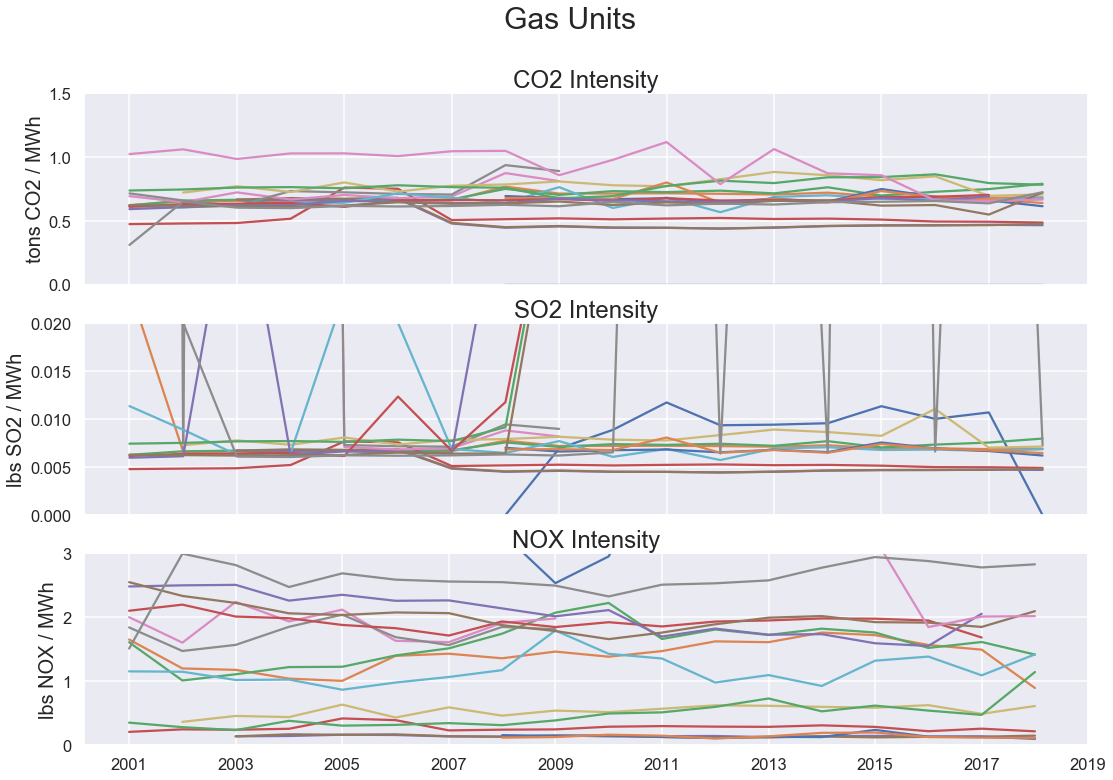

In [15]:
fuel = 'Gas'
plotEI_allUnits_allYears(CO2I_gas, SO2I_gas, NOXI_gas, fuel)

Coal

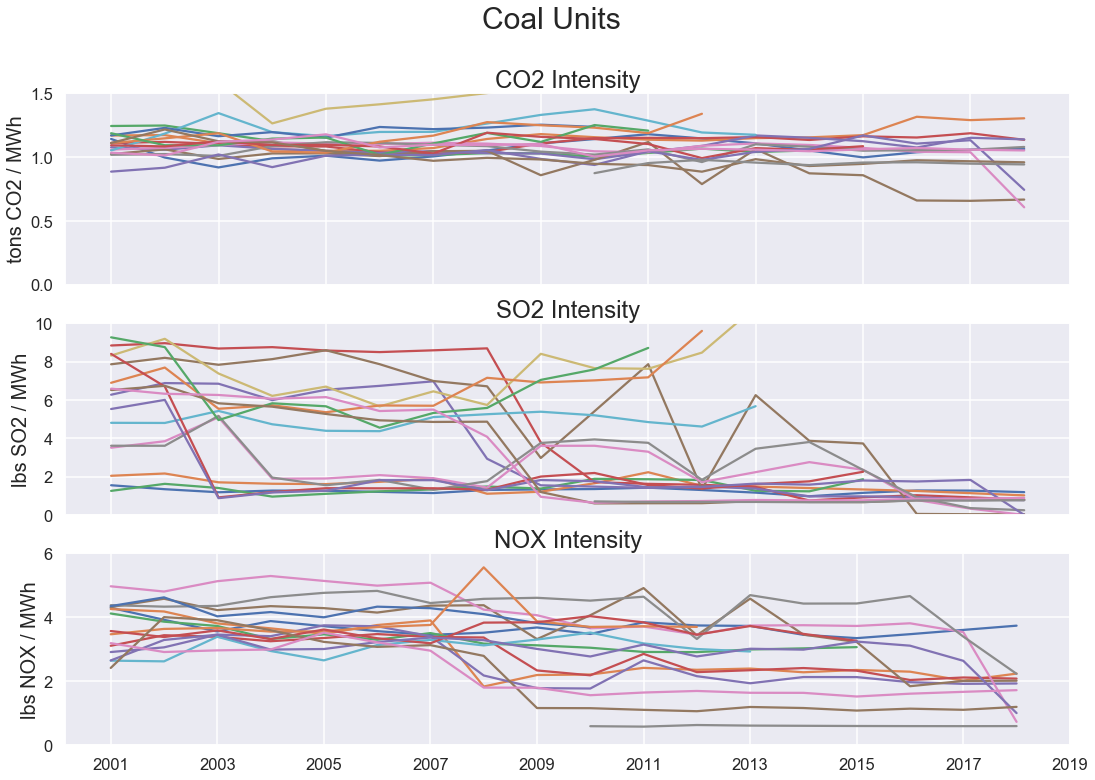

In [16]:
fuel = 'Coal'
plotEI_allUnits_allYears(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

Some of the lines above overlap, and there are tons of colors. These charts are very difficult to read, so let's try a different approach.

2\. Heat maps of emissions intensity

In [17]:
def plotEI_heatmap(CO2I, SO2I, NOXI, fuel):
    endOfMetadata = list(CO2I.columns).index('2001')
    # axis lims
    cmap = sns.cm.rocket_r
    if fuel == 'Gas':
        co2_color_min = 0
        co2_color_max = 1
        so2_color_min = 0
        so2_color_max = 0.02
        nox_color_min = 0
        nox_color_max = 0.5
    else:  # coal
        co2_color_min = .9
        co2_color_max = 1.3
        so2_color_min = 0
        so2_color_max = 10
        nox_color_min = 0
        nox_color_max = 6

    # extract data + sort by average
    co2 = CO2I.iloc[:, endOfMetadata:]
    co2['mean'] = co2.mean(axis=1)
    co2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    so2 = SO2I.iloc[:, endOfMetadata:]
    so2['mean'] = so2.mean(axis=1)
    so2.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    nox = NOXI.iloc[:, endOfMetadata:]
    nox['mean'] = nox.mean(axis=1)
    nox.sort_values('mean', ascending=False, inplace=True)#.drop(['mean'], axis=1, inplace=True)

    # plot
    fig3 = plt.figure(figsize=(18, 8))
    ax1 = fig3.add_subplot(311)
    ax1 = sns.heatmap(co2, vmin=co2_color_min, vmax=co2_color_max, cmap=cmap)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.ylabel('Units')
    plt.title('CO2 Intensity')

    ax2 = fig3.add_subplot(312)
    ax2 = sns.heatmap(so2, vmin=so2_color_min, vmax=so2_color_max, cmap=cmap)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.ylabel('Units')
    plt.title('SO2 Intensity')

    ax3 = fig3.add_subplot(313)
    ax3 = sns.heatmap(nox, vmin=nox_color_min, vmax=nox_color_max, cmap=cmap)
    plt.setp(ax3.get_yticklabels(), visible=False)
    plt.ylabel('Units')
    plt.title('NOX Intensity')

    plt.suptitle(fuel + ' Units', fontsize=30)
    plt.show()

Gas

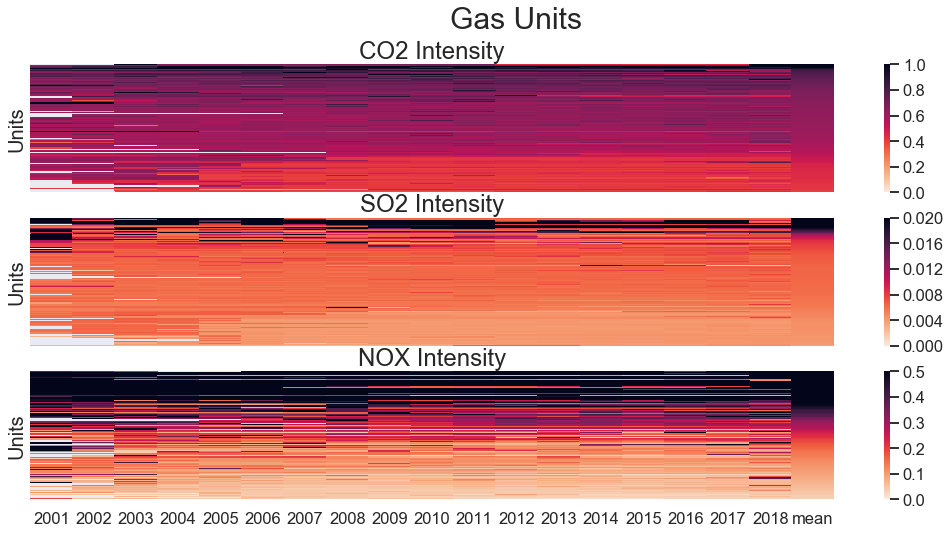

In [18]:
fuel = 'Gas'
plotEI_heatmap(CO2I_gas, SO2I_gas, NOXI_gas, fuel)

Coal

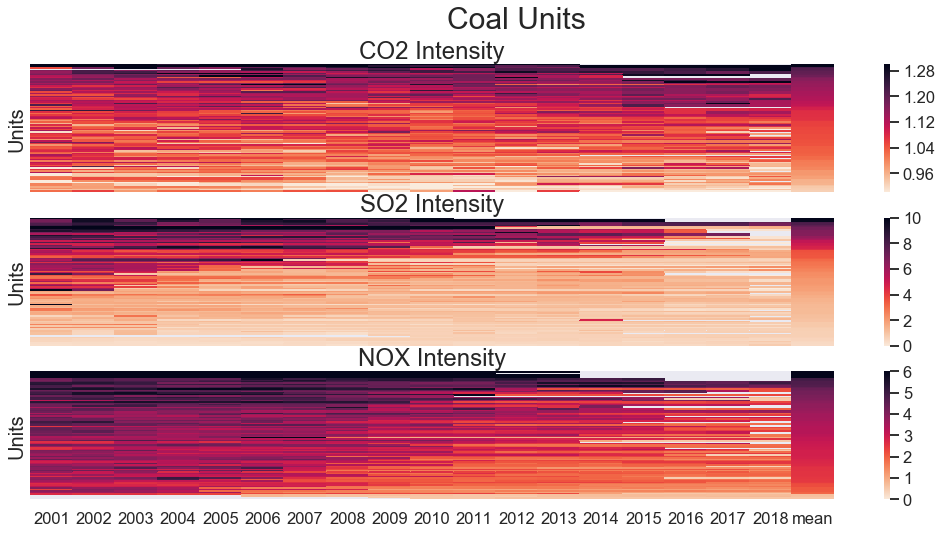

In [19]:
fuel = 'Coal'
plotEI_heatmap(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

The temporal trends in NOX and SO2 are striking here. Note a few things:

1. Both SO2I and NOXI have decreased sharply since 2001.
2. For each unit, there is a step change where emissions controls are incorporated...
3. ...Or, for the worst offenders (black), there is no data in the later periods because operators chose to shutter the plants instead of upgrading emissions controls.
4. For CO2, it's very difficult to see a compelling temporal trend. However, there is a slight increase in the more CO2 intense plants, and a possible decrease in the less CO2 plants. This needs further investigation.


3\. Interpolate, then replot heat map

In [20]:
def filterForBothHavles(df, thresh):
    # Ensure both halves of time series have substantial data to allow for before/after comparison
    # Thresh = max NaNs in either half of the data
    copy = df.copy()
    for ind, row in copy.iterrows():
        H1 = row[endOfMetadata:endOfMetadata+9]
        H2 = row[endOfMetadata+9:]
        if sum(H1.isnull()) > thresh or sum(H2.isnull()) > thresh:
            copy.drop(ind, axis=0, inplace=True)
    print(copy.shape)
    return copy

Investigate how much data we cut at each threshold step

In [21]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_gas, i)

If it can't have more than 3 NaNs in either half:
(290, 23)
If it can't have more than 4 NaNs in either half:
(317, 23)
If it can't have more than 5 NaNs in either half:
(350, 23)
If it can't have more than 6 NaNs in either half:
(373, 23)
If it can't have more than 7 NaNs in either half:
(417, 23)
If it can't have more than 8 NaNs in either half:
(448, 23)
If it can't have more than 9 NaNs in either half:
(485, 23)


In [22]:
for i in range(3, 10):
    print("If it can't have more than", i, "NaNs in either half:")
    data = filterForBothHavles(CO2I_coal, i)

If it can't have more than 3 NaNs in either half:
(74, 23)
If it can't have more than 4 NaNs in either half:
(77, 23)
If it can't have more than 5 NaNs in either half:
(84, 23)
If it can't have more than 6 NaNs in either half:
(85, 23)
If it can't have more than 7 NaNs in either half:
(86, 23)
If it can't have more than 8 NaNs in either half:
(88, 23)
If it can't have more than 9 NaNs in either half:
(89, 23)


Interpolate values with splines when we have valid values on either side. Interpolates up to 3 consecutive years. Often this type of missing data is present in peaker plants, when there was no operation over that period.

In [23]:
CO2I_gas = CO2I_gas.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')

In [24]:
CO2I_coal = CO2I_coal.interpolate(method='spline', order=3, axis=0, limit=3, limit_area='inside')

(86, 23)
(74, 23)
(74, 23)


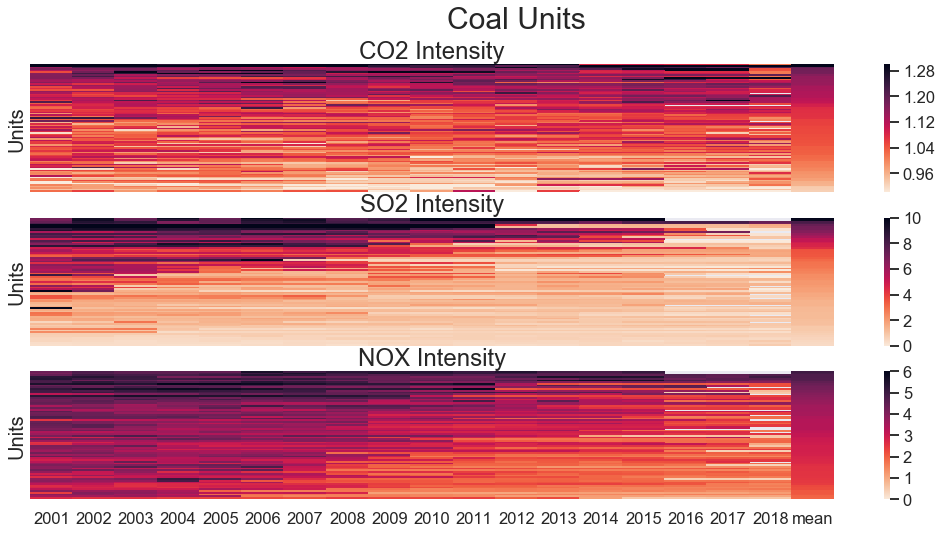

In [25]:
fuel = 'Coal'
thresh = 3
CO2I_coal = filterForBothHavles(CO2I_coal, thresh)
SO2I_coal = filterForBothHavles(SO2I_coal, thresh)
NOXI_coal = filterForBothHavles(NOXI_coal, thresh)
plotEI_heatmap(CO2I_coal, SO2I_coal, NOXI_coal, fuel)

(367, 23)
(290, 23)
(290, 23)


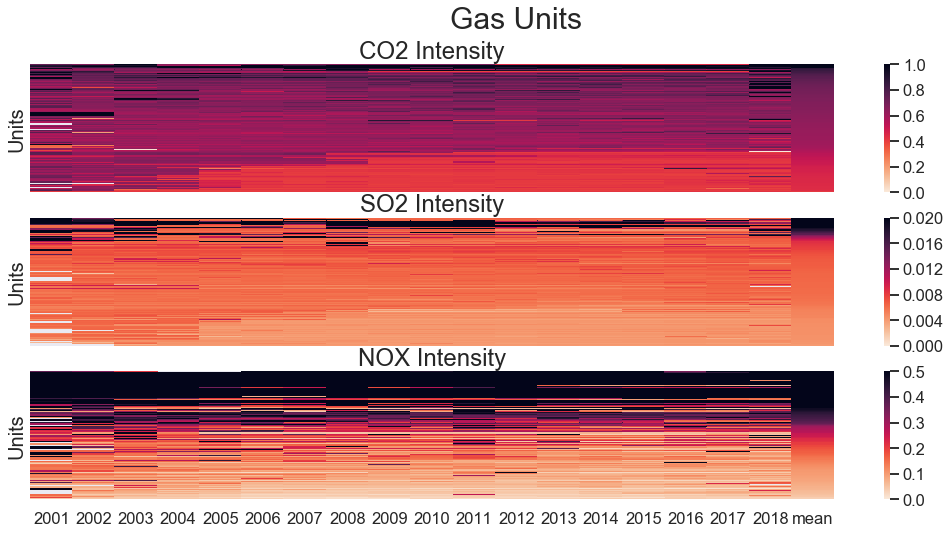

In [26]:
fuel = 'Gas'
thresh = 3
CO2I_gas = filterForBothHavles(CO2I_gas, thresh)
SO2I_gas = filterForBothHavles(SO2I_gas, thresh)
NOXI_gas = filterForBothHavles(NOXI_gas, thresh)
plotEI_heatmap(CO2I_gas, SO2I_gas, NOXI_gas, fuel)

Investigate gas plants with very low EI

In [27]:
CO2I_gas_low = CO2I_gas[(CO2I_gas.iloc[:, endOfMetadata+6:] < 0.5).all('columns')]
CO2I_gas_low

,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
318,117,CC5A,APS West Phoenix Power Plant,NG,CO2,0.569899,0.615619,0.666746,0.662775,0.668656,...,0.456814,0.446406,0.445931,0.439843,0.446997,0.459097,0.464581,0.464688,0.469385,0.466353
321,117,CC5B,APS West Phoenix Power Plant,NG,CO2,0.571317,0.616572,0.666162,0.678219,0.673285,...,0.459958,0.447819,0.445937,0.439997,0.448340,0.460579,0.464961,0.466264,0.466639,0.477000
420,260,1A,Moss Landing,NG,CO2,0.616212,0.657750,0.662925,0.656770,0.475055,...,0.429915,0.424829,0.430343,0.419588,0.425241,0.428413,0.422555,0.417034,0.407511,0.410145
423,260,2A,Moss Landing,NG,CO2,0.617511,0.659137,0.665496,0.656658,0.475837,...,0.432403,0.426200,0.427073,0.419364,0.425777,0.429812,0.430273,0.418726,0.408526,0.405370
426,260,3A,Moss Landing,NG,CO2,0.618806,0.649741,0.657997,0.661107,0.482594,...,0.426758,0.427108,0.430320,0.421111,0.427931,0.429287,0.430179,0.418649,0.411386,0.408908
429,260,4A,Moss Landing,NG,CO2,NaN,0.645974,0.653638,0.658594,0.482284,...,0.427092,0.424981,0.426868,0.418346,0.424370,0.424879,0.424257,0.415646,0.404369,0.403245
681,400,10,Haynes Generating Station,NG,CO2,0.712650,0.672197,0.709712,0.445549,0.418747,...,0.422120,0.410470,0.409716,0.413349,0.403429,0.410425,0.411999,0.405859,0.405478,0.406514
717,400,9,Haynes Generating Station,NG,CO2,0.722938,0.672748,0.710414,0.724791,0.418902,...,0.422072,0.409137,0.412038,0.413380,0.400632,0.406223,0.405663,0.404244,0.405158,0.402095
747,408,6,Valley Gen Station,NG,CO2,0.730875,0.672718,0.555452,0.424507,0.420172,...,0.422700,0.418556,0.421227,0.410692,0.414319,0.411164,0.411484,0.416607,0.417677,0.449328
750,408,7,Valley Gen Station,NG,CO2,0.731636,0.672692,0.317418,0.423467,0.424013,...,0.421636,0.416946,0.419871,0.412340,0.414834,0.412411,0.412420,0.418735,0.420164,0.421467


In [28]:
# fig2 = plt.figure(figsize=(12, 14))
# ax1 = fig2.add_subplot(311)
# ax1 = sns.clustermap(CO2I.iloc[:, 4:].fillna(0))

The bottom third of the gas CO2I plants are CCGT.

In [30]:
CO2I_gas_high = CO2I_gas[(CO2I_gas.iloc[:, endOfMetadata+6:] > 0.75).all('columns')]
CO2I_gas_high

,ORISPL_CODE,UNITID,NAME,FUEL,GAS,2001,2002,2003,2004,2005,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
573,341,1,Long Beach Generating Station,NG,CO2,0.677110,0.666032,0.701027,0.713980,0.723453,...,0.911334,0.993005,0.959369,0.928898,0.892592,0.918260,0.899214,0.908919,0.925790,0.946476
576,341,2,Long Beach Generating Station,NG,CO2,NaN,0.666306,0.701416,0.714463,0.723862,...,0.905401,0.982555,0.933042,0.966128,0.924019,0.959705,0.925235,0.939687,0.972957,0.982742
579,341,3,Long Beach Generating Station,NG,CO2,NaN,NaN,0.701795,0.714934,0.724254,...,0.924122,0.999362,0.963534,1.016732,1.002358,0.985183,1.000962,0.995955,1.032197,1.004832
600,356,5,AES Redondo Beach,NG,CO2,0.737062,0.802579,0.859289,1.017552,1.321536,...,0.962442,1.163153,1.121805,1.015150,0.996467,0.975998,0.919597,1.039609,1.060726,1.642446
603,356,6,AES Redondo Beach,NG,CO2,0.748793,0.841658,0.825316,1.011249,1.222363,...,1.021764,0.817397,1.016194,0.910363,1.091111,0.932172,1.050745,1.063931,1.168668,0.904115
633,377,4,Grayson Power Plant,NG,CO2,0.933363,1.171270,1.277821,1.170408,1.070747,...,1.087847,1.080493,1.004609,1.209247,1.165069,1.164697,1.158579,1.122234,0.956917,0.992865
636,377,5,Grayson Power Plant,NG,CO2,0.936406,1.156195,1.221804,1.040083,1.027971,...,1.048761,1.041450,1.189870,1.243968,1.091467,1.134083,1.098738,1.125027,0.998622,0.953712
1014,6761,A,Rawhide Energy Station,NG,CO2,0.772754,0.778513,0.789035,0.781478,0.772282,...,0.810285,0.777585,0.808892,0.787845,0.795105,0.755383,0.768954,0.772042,0.826702,0.913529
1020,6761,C,Rawhide Energy Station,NG,CO2,NaN,0.717645,0.763827,0.781627,0.757761,...,0.828656,0.769190,0.754860,0.763508,0.768313,0.765929,0.842413,0.757937,0.796875,0.839792
1191,10682,GT2,Brush Power Projects,NG,CO2,1.481863,1.479071,1.600218,1.545978,1.184936,...,0.858393,0.886544,0.889029,0.906093,0.927448,0.888872,0.865940,0.882832,0.946845,0.922560


Plants with the worst emissions intensity are simple cycle. No surprises there.